In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dsde-scrape/scraped_data_1k.csv
/kaggle/input/cleaned-dsde-project/final_df.csv


In [51]:
!pip install -q qdrant-client sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [52]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams, Distance, PointStruct
from sentence_transformers import SentenceTransformer
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
QDRANT_API_KEY = user_secrets.get_secret("qdrant")
QDRANT_HOST = "07961b0b-8262-43ec-9fcb-1552dd055ebd.us-east4-0.gcp.cloud.qdrant.io"  # Replace with your actual host

# Connect to Qdrant Cloud
client = QdrantClient(
    url=f"https://{QDRANT_HOST}",
    api_key=QDRANT_API_KEY,
)

In [53]:
model = SentenceTransformer('kornwtp/ConGen-simcse-model-roberta-base-thai')

In [ ]:
import ast
def normalize_coordinates(coords):
    coords_np = np.array(coords)

    # Ensure it's a 2D array (n_samples, 2)
    if coords_np.ndim == 1:
        coords_np = np.stack(coords_np)

    coord_min = coords_np.min(axis=0)
    coord_max = coords_np.max(axis=0)
    normalized_coords = (coords_np - coord_min) / (coord_max - coord_min + 1e-8)
    return normalized_coords, coord_min, coord_max

def transform_coordinates(coords,coord_min,coord_max):
    coords_np = np.array(coords)

    # Ensure it's a 2D array (n_samples, 2)
    if coords_np.ndim == 1:
        coords_np = np.stack(coords_np)

    normalized_coords = (coords_np - coord_min) / (coord_max - coord_min + 1e-8)
    return normalized_coords

def parse_coords(coord_str):
    try:
        # Convert string like "[13.75,100.50]" to list
        lat, lon = ast.literal_eval(coord_str)
        return [lon, lat]  # Convert to [lon, lat]
    except Exception:
        return np.nan

def preprocess_texts(texts, max_char_len=100):
    cleaned = []
    for t in texts:
        if not isinstance(t, str):
            continue
        t = t.strip()
        if len(t) == 0:
            continue
        cleaned.append(t[:max_char_len])  # truncate long ones
    return cleaned

# **Deal with a SCRAPED data which is mismatch from old data**

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
scrape = pd.read_csv("/kaggle/input/dsde-scrape/scraped_data_1k.csv")
selected_columns = ["type","organization","comment","longitude","latitude"]
scrape = scrape[selected_columns]

In [57]:
import re
interested_type = ['PM2.5', 'การเดินทาง', 'กีดขวาง',
       'คนจรจัด', 'คลอง', 'ความปลอดภัย', 'ความสะอาด', 'จราจร', 'ต้นไม้', 'ถนน',
       'ทางเท้า', 'ท่อระบายน้ำ', 'น้ำท่วม', 'ป้าย', 'ป้ายจราจร', 'ร้องเรียน',
       'สอบถาม', 'สะพาน', 'สัตว์จรจัด', 'สายไฟ', 'ห้องน้ำ', 'เสนอแนะ',
       'เสียงรบกวน', 'แสงสว่าง']

# Function to clean and parse a type string
def parse_type_string(s):
    if not isinstance(s, str):
        return []
    s = s.strip("[]")
    items = re.split(r'[,&]', s)
    return [item.strip() for item in items if item.strip()]


# Create one-hot columns
for itype in interested_type:
    scrape[itype] = scrape['type'].apply(lambda x: int(itype in parse_type_string(x)))
scrape['coords'] = scrape.apply(lambda row: [row['latitude'], row['longitude']], axis=1)
scrape.drop(columns=['type','longitude','latitude'], inplace = True)

In [58]:
train2, test2 = train_test_split(
    scrape,
    test_size=0.2,
    random_state=42              
)

# **Merge with old date**

In [59]:
df = pd.read_csv('/kaggle/input/cleaned-dsde-project/final_df.csv', index_col=0)
df['coords'] = df['coords'].apply(parse_coords)

In [72]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    df,
    test_size=0.2,              
    stratify=df['organization'],
    random_state=42              
)
train = pd.concat([train, train2], ignore_index=True)
test = pd.concat([test, test2], ignore_index=True)

# **Upload to qdrant**

In [61]:
def batch_upload(client, collection_name, points, batch_size=1000):
    for i in range(0, len(points), batch_size):
        batch = points[i:i+batch_size]
        client.upsert(collection_name=collection_name, points=batch)

In [ ]:
def upload_to_qdrant(train):
    # Extract and remove 'organization', 'comment', and 'coords' from the DataFrame
    organizations = train.pop('organization').tolist()
    texts = train.pop("comment").tolist()
    texts = preprocess_texts(texts, 800)
    coords = train.pop('coords').values
    types = train.to_numpy()
    
    # Normalize coordinates 
    normalized_coords, coord_min, coord_max = normalize_coordinates(coords)
    
    # Embed the text using the Thai model
    text_vecs = model.encode(texts)
    
    # # Embed and Normalize vecs
    # text_vecs = model.encode(texts)
    # text_vecs = text_vecs / np.linalg.norm(text_vecs, axis=1, keepdims=True)
    
    # Combine text embeddings with coordinates (hstack)
    combined_vectors = np.hstack([text_vecs, normalized_coords, types])
    
    # Define the collection name
    collection_name = "dsde_project"
    
    # Only create the collection if it doesn't already exist
    if collection_name not in [col.name for col in client.get_collections().collections]:
        client.create_collection(
            collection_name=collection_name,
            vectors_config=VectorParams(size=combined_vectors.shape[1], distance=Distance.COSINE),
        )
    
    # Prepare the points to upsert into Qdrant, including 'organization' in payload
    points = [
        PointStruct(
            id=i,
            vector=combined_vectors[i].tolist(),
            payload={
                "organization": organizations[i]
            }
        )
        for i in range(len(texts))
    ]
    
    # Upload the points in batches
    batch_upload(client, collection_name, points, batch_size=1000)
    return coord_min, coord_max

In [ ]:
coord_min, coord_max= upload_to_qdrant(train)

Batches:   0%|          | 0/5072 [00:00<?, ?it/s]

In [ ]:
print(coord_min, coord_max)

# **Evaluation**

In [74]:
from qdrant_client.http.models import SearchRequest

In [ ]:
test_y = test.pop('organization')
test_texts = test.pop("comment").tolist()
test_texts = preprocess_texts(test_texts,800)
test_coords = test.pop('coords').values
test_types = test.to_numpy()

# Normalize coordinates 
test_normalized_coords = transform_coordinates(test_coords)

# Embed the text using the Thai model
test_text_vecs = model.encode(test_texts)
# test_text_vecs = test_text_vecs / np.linalg.norm(test_text_vecs, axis=1, keepdims=True)

# Combine text embeddings with coordinates (hstack)
query_vectors = np.hstack([test_text_vecs, test_normalized_coords, test_types])

Batches:   0%|          | 0/1268 [00:00<?, ?it/s]

In [76]:
def batch_query(client, collection_name, query_vectors, batch_size=1000, top_k=5):
    results = []
    for i in range(0, len(query_vectors), batch_size):
        batch = query_vectors[i:i + batch_size]
        # Prepare search requests for the batch
        search_requests = [
            SearchRequest(
                vector=vec.tolist(),
                limit=top_k,
                with_payload=True
            ) for vec in batch
        ]
        
        # Perform batch search
        result_batch = client.search_batch(
            collection_name=collection_name,
            requests=search_requests,

        )
        
        # Collect the results
        results.extend(result_batch)
    
    return results

In [78]:
results = batch_query(client, collection_name="dsde_project", query_vectors=query_vectors, batch_size=80, top_k=5)

/tmp/ipykernel_31/160039704.py:15: DeprecationWarning: `search_batch` method is deprecated and will be removed in the future. Use `query_batch_points` instead.
  result_batch = client.search_batch(


In [ ]:
from collections import Counter

In [79]:
print(results[0])

[ScoredPoint(id=95710, version=95, score=0.7819802, payload={'organization': 'เขตราชเทวี,สน.พญาไท,สำนักงานตำรวจแห่งชาติ (Royal Thai Police),กองบัญชาการตำรวจนครบาล (บช.น.),กองบังคับการตำรวจนครบาล 1 (บก.น.1)'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=119605, version=119, score=0.7483364, payload={'organization': 'เขตจตุจักร,สน.พหลโยธิน,สำนักงานตำรวจแห่งชาติ (Royal Thai Police),กองบัญชาการตำรวจนครบาล (บช.น.),กองบังคับการตำรวจนครบาล 2 (บก.น.2)'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=123629, version=123, score=0.73732823, payload={'organization': 'เขตจตุจักร,ฝ่ายเทศกิจ เขตจตุจักร,ผอ.เขตจตุจักร (นางสาวภัทร์กร),กลุ่มกรุงเทพเหนือ (นางวันทนีย์ วัฒนะ)'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id=82250, version=82, score=0.73646426, payload={'organization': 'เขตบางพลัด,สน.บางพลัด,สำนักงานตำรวจแห่งชาติ (Royal Thai Police),กองบัญชาการตำรวจนครบาล (บช.น.),กองบังคับการตำรวจนครบาล 7 (บก.น.7)'}, vector=None, shard_key=None, order_valu

In [81]:
all_organizations = [[point.payload.get("organization") for point in result] for result in results]
test_y = test_y.reset_index(drop=True)

intop5 = 0
k = [0,0,0,0,0]

for i in range(test.shape[0]):
    pred = all_organizations[i]
    gt = test_y.iloc[i]

    if gt in pred:
        intop5 += 1
        
    for j in range(1,6):
        most_common_label = Counter(pred[:j]).most_common(1)[0][0]
        if most_common_label == gt:
            k[j-1] += 1

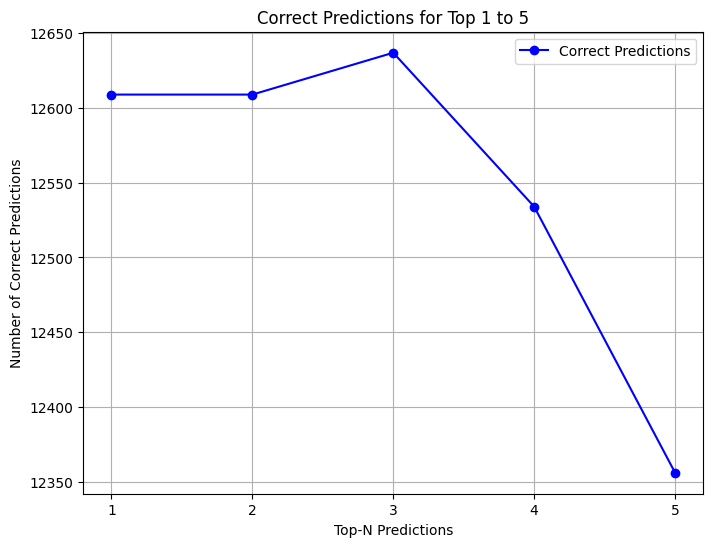

In [82]:
import matplotlib.pyplot as plt
# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), k, marker='o', linestyle='-', color='b', label='Correct Predictions')

# Add labels and title
plt.title("Correct Predictions for Top 1 to 5")
plt.xlabel("Top-N Predictions")
plt.ylabel("Number of Correct Predictions")
plt.xticks(range(1, 6))  # Ensure the x-axis has ticks for 1 to 5
plt.grid(True)

# Show the plot
plt.legend()
plt.show()

In [83]:
accuracy = intop5 / test.shape[0]
print(f"Top-5 Accuracy: {accuracy:.4f}")

# Convert to accuracy by dividing by number of samples
k_accuracy = [correct / len(test_y) for correct in k]

# Print results
for idx, acc in enumerate(k_accuracy, 1):
    print(f"k={idx} Accuracy: {acc:.4f}")

Top-5 Accuracy: 0.4625
k=1 Accuracy: 0.3108
k=2 Accuracy: 0.3108
k=3 Accuracy: 0.3115
k=4 Accuracy: 0.3089
k=5 Accuracy: 0.3045
